In [5]:
import numpy as np
import pandas as pd
from Bio import SeqUtils
from Bio import SeqIO
import random
import pylab 
import scipy.stats as stats
from scipy.stats import kstest, norm
from scipy.stats import shapiro
import matplotlib.pyplot as plt 

In [188]:
#load representative sequences into list

df = pd.read_csv('final file hopefully no errors.csv')
dfp = df.loc[df['Gen'] == 'ssRNA(+)']
dfn = df.loc[df['Gen'] == 'ssRNA(-)']

pndf = pd.concat([dfp, dfn]).reset_index(drop = True)
pndf['Len'] = [len(s) for s in pndf['Seq'].to_list()]


ParserError: Error tokenizing data. C error: out of memory

In [193]:
#merge tax with pndf

tax = pd.read_csv('id desc tax.csv')
tax = tax[['Id', 'Tax']].copy()

pndf = pd.merge(pndf,tax, on = 'Id', how = 'left')

In [7]:
#make transition matrix from query sequence
#starter code from https://stackoverflow.com/questions/46657221/generating-markov-transition-matrix-in-python

def transition_matrix(queryseq):
    
    transitions = []
    
    for letter in queryseq:
        if letter == 'A':
            transitions.append(1)
        elif letter == 'T':
            transitions.append(2)
        elif letter == 'G':
            transitions.append(3)
        elif letter == 'C':
            transitions.append(4) 
    
    n = 5 #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return np.array(M)[1:,1:]

#test:

t = 'GATAasdfCA'
m = transition_matrix(t)
for row in m: print(' '.join('{0:.2f}'.format(x) for x in row))

0.00 0.50 0.00 0.50
1.00 0.00 0.00 0.00
1.00 0.00 0.00 0.00
1.00 0.00 0.00 0.00


In [17]:
#column names

lets = 'ATGC'
tcols = []
for i in range(4):
    a = lets[i]
    for j in range(4):
        tcols.append((a + ' to ' + lets[j]))

In [97]:
m.flatten()/2

array([0.13605956, 0.12688822, 0.13282262, 0.10422961, 0.10879505,
       0.1190156 , 0.13770845, 0.1344809 , 0.16376773, 0.09633396,
       0.13901525, 0.10088306, 0.17599895, 0.12329127, 0.05822818,
       0.1424816 ])

In [111]:
#raw transition scores

l = []
for s in pndf['Seq'].tolist():
    m = transition_matrix(s)
    f = m.flatten()
    l.append(f)
    
tdfr = pd.DataFrame(l, columns = tcols)

In [100]:
#transition scores as a function of length

l = []
for s in pndf['Seq'].tolist():
    m = transition_matrix(s)
    f = m.flatten() / (len(s)/1000)
    
    l.append(f)
    
tdf = pd.DataFrame(l, columns = tcols)

In [112]:
tdfp = tdf.iloc[:2862,:]
tdfn = tdf.iloc[2862:, :].reset_index(drop = True)
tdfrp = tdfr.iloc[:2862,:]
tdfrn = tdfr.iloc[2862:, :].reset_index(drop = True)

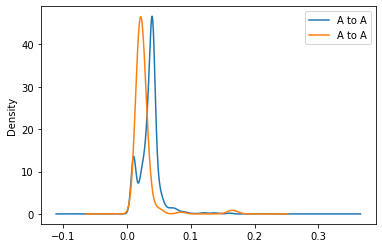

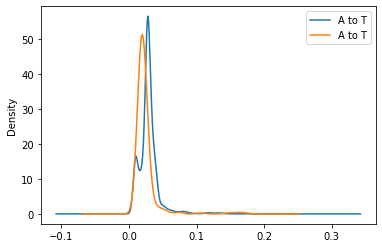

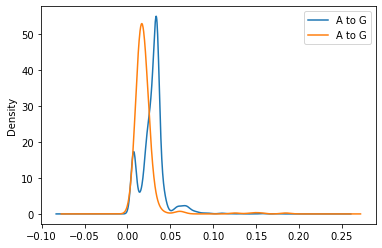

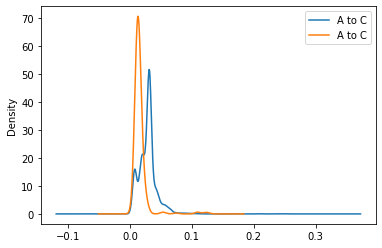

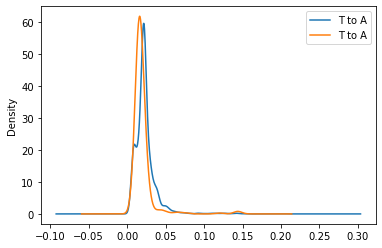

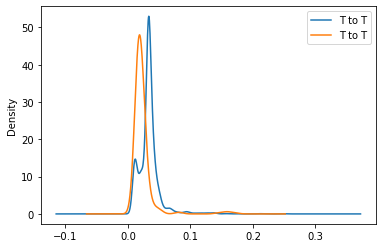

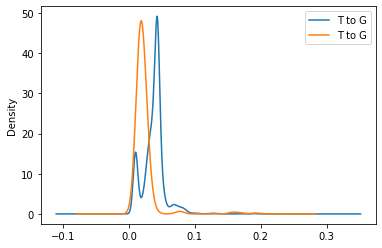

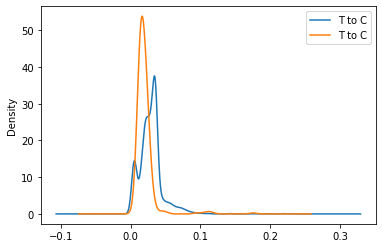

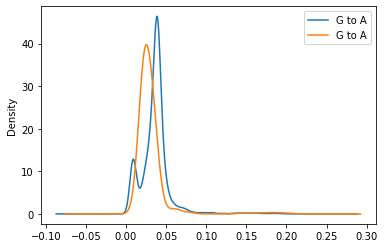

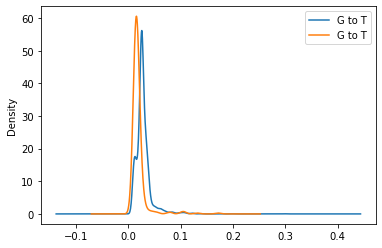

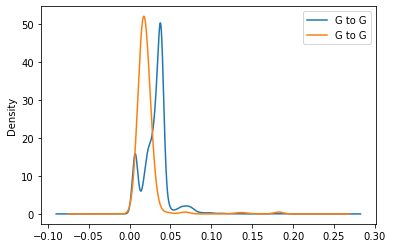

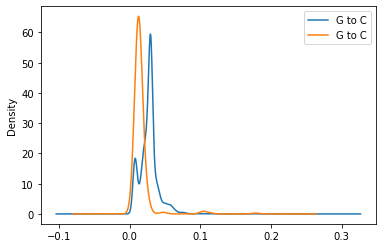

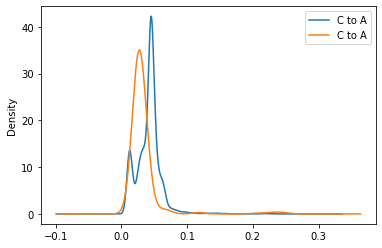

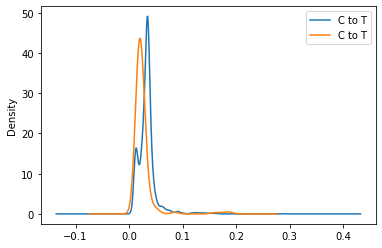

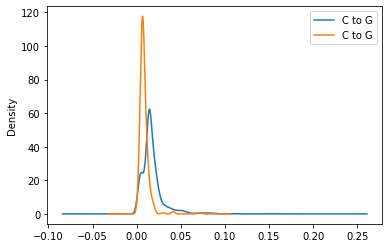

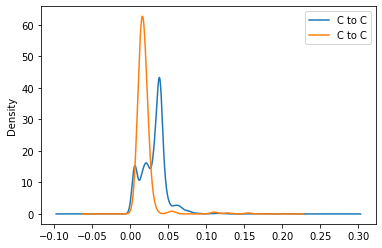

In [239]:
for i in range(16):
    pd.concat([tdfp.iloc[:, i], tdfn.iloc[:, i]], axis = 1).plot(kind='kde')

check data normalcy

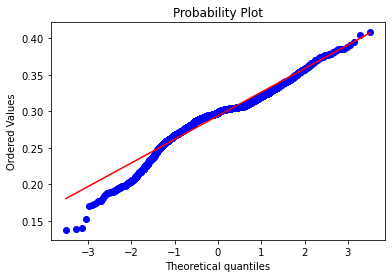

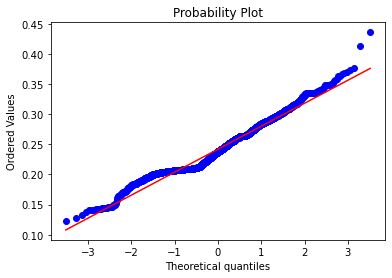

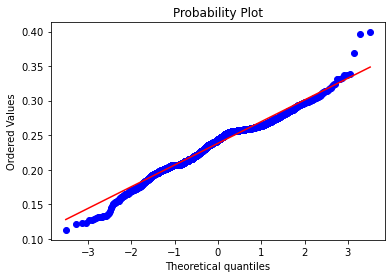

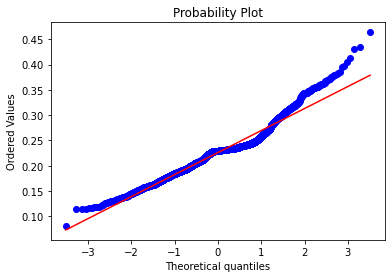

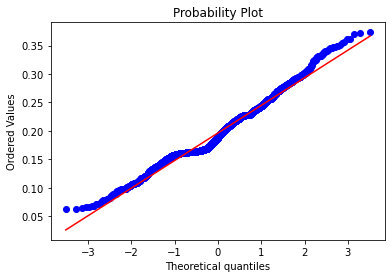

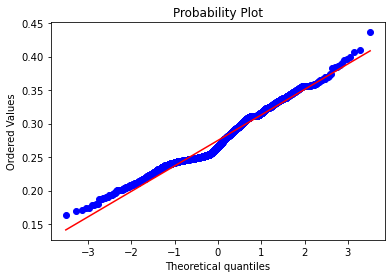

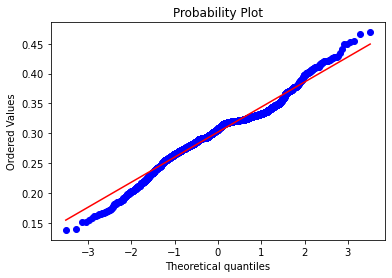

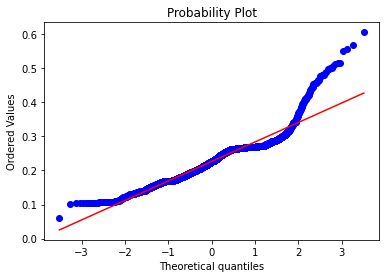

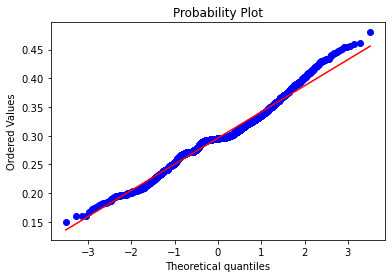

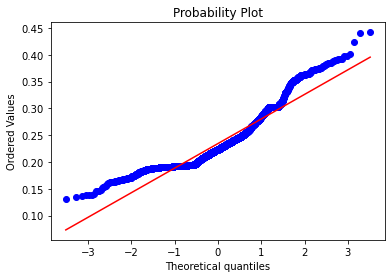

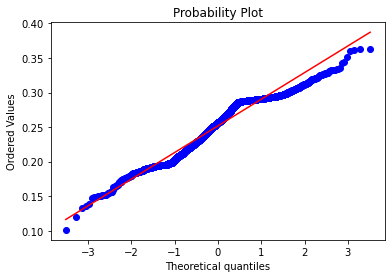

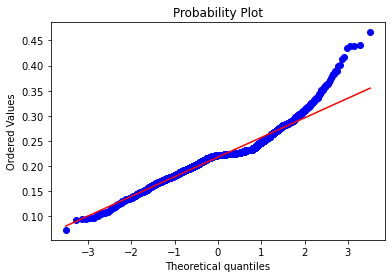

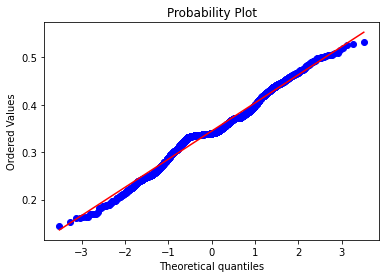

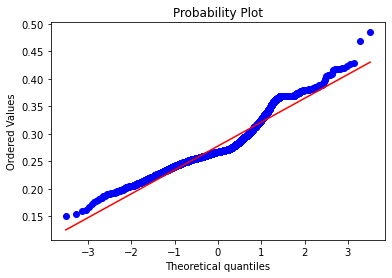

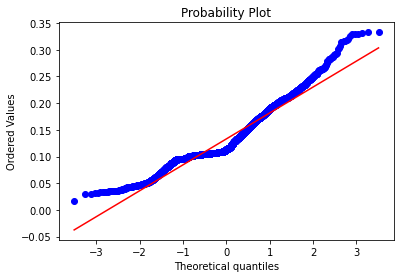

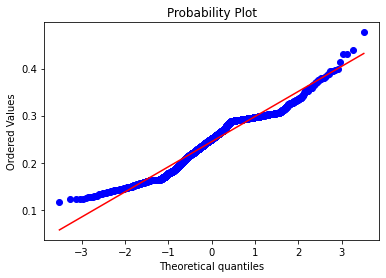

In [115]:
#qqplots

for i in range(16):
    x = tdfr.iloc[:,i].values
    stats.probplot(x, dist="norm", plot=pylab)
    pylab.show()

#tdfr looks fairly normal
#tdf doesn't

In [117]:
#Kolmogorov Smirnov test

for i in range(16):
    ks_statistic, p_value = kstest(tdfr.iloc[:,i], 'norm')
    print(ks_statistic, p_value)
    
#neither tdf or tdfr is not normally distributed

0.5693443461657656 0.0
0.5548296427859614 0.0
0.5525689910718361 0.0
0.5457335963840776 0.0
0.5278070861140267 0.0
0.5714299852231735 0.0
0.5639795429597823 0.0
0.5404705778263879 0.0
0.5684959474481922 0.0
0.5585590849226785 0.0
0.557325641103055 0.0
0.539497296351947 0.0
0.5680743978746081 0.0
0.5702833811929233 0.0
0.511678744633504 0.0
0.5486119127565645 0.0


In [119]:
#Shapiro Wilk test

for i in range(16):
    print(shapiro(tdfr.iloc[:,i]))

#nothing is normally distributed

(0.9464271664619446, 2.1685934145728225e-32)
(0.9646422863006592, 4.229698069728093e-27)
(0.9759968519210815, 1.28849145001464e-22)
(0.955074667930603, 4.345857534086067e-30)
(0.9750211834907532, 4.6640580605850893e-23)
(0.9674422144889832, 4.1445827513938654e-26)
(0.9704908132553101, 5.930927949425802e-25)
(0.9271527528762817, 1.2694605381108662e-36)
(0.9776471853256226, 7.722357563067876e-22)
(0.9023180603981018, 6.447794623897781e-41)
(0.9513493776321411, 4.050113593809015e-31)
(0.9428683519363403, 2.9711218484468267e-33)
(0.9774918556213379, 6.4982564742342305e-22)
(0.9303356409072876, 5.442789956991998e-36)
(0.9357430338859558, 7.321231938507492e-35)
(0.9596309065818787, 9.835628531341502e-29)


In [109]:
#how transition probabilites change as a function of length

len_score = []

for i in range(1,20000,500):
    rs = ''.join(random.choice('ATGC') for _ in range(i))
    
    m = transition_matrix(rs)
    for ms in m.flatten():
        len_score.append((len(rs), ms))

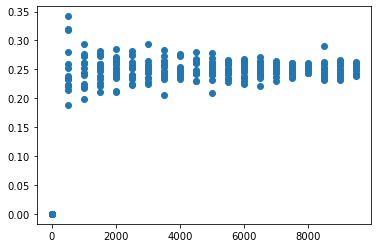

In [110]:
a = np.array(len_score)
plt.scatter(a[:,0],a[:,1])

#matrix scores can be unstable for shorter random sequences smaller than 5k. 

In [128]:
#transition probabilities for real sequences

len_score = []

for s in pndf['Seq'].to_list():
    m = transition_matrix(s)
    temp = []
    for ms in m.flatten():
        temp.append((len(s), ms))
    len_score.append(temp)

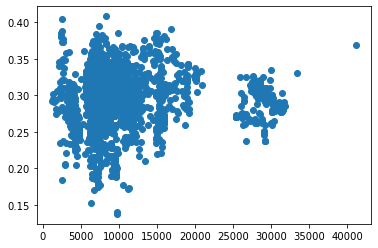

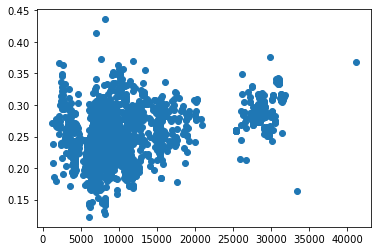

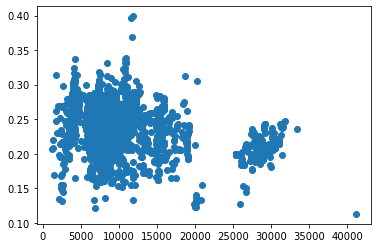

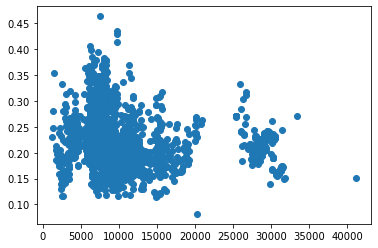

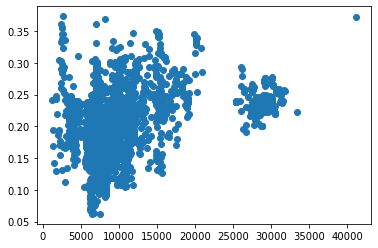

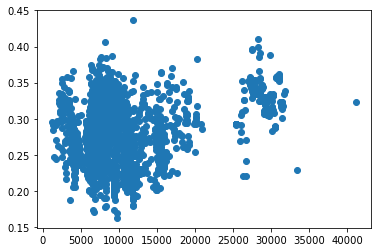

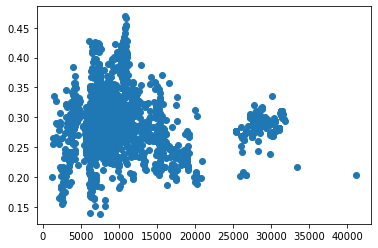

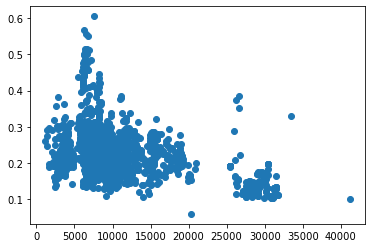

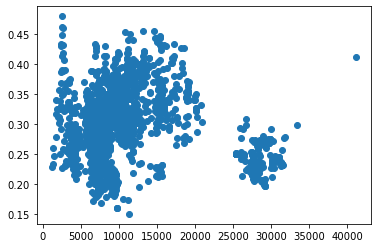

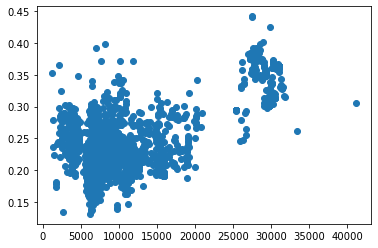

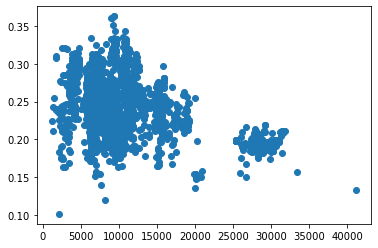

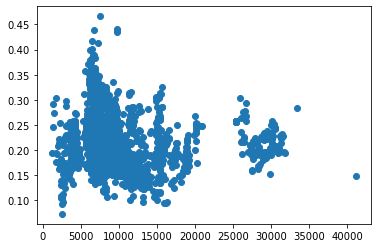

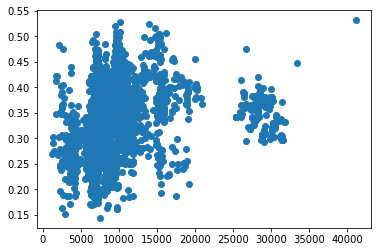

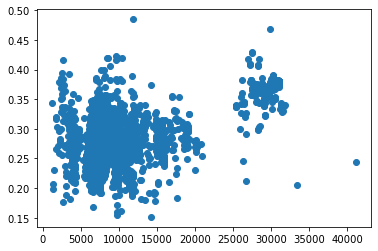

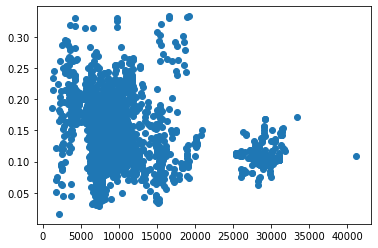

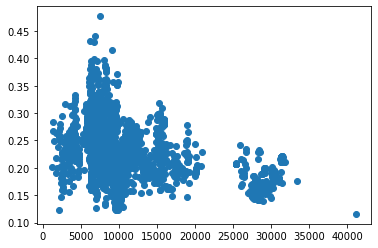

In [146]:
for i in range(16):
    temp = (lsdf.iloc[:,i].to_list())
    a = np.array(temp)
    plt.scatter(a[:,0],a[:,1])
    plt.show()
    
    
#transition probabilities are much more stable for sequences over 22k

In [172]:
pndf.loc[pndf['Gen'] == 'ssRNA(+)'].loc[pndf['Len'] > 20000]

#355 +ssRNA sequences greater than 22k. 12% of sequences 
#367 above 20k. over 326 of them are coronaviruses. rest are tornidoviridae and mesnidoviridae
#no CoVs or tornidoviridaes between 15k and 20k. few mesnidoviridae

,Id,Org,MolTyp,Topol,Des,Gen,Seq,Len
0,MT291826.1,Severe acute respiratory syndrome coronavirus 2,RNA,linear,Severe acute respiratory syndrome coronavirus ...,ssRNA(+),TGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATT...,29807
3,NC_032730.1,Lucheng Rn rat coronavirus,RNA,linear,"Lucheng Rn rat coronavirus isolate Lucheng-19,...",ssRNA(+),ACTTTTAGAGTATAATCTATTATACATAGATTTGCACTAACCCCTC...,28763
5,MN262644.1,Avian coronavirus,RNA,linear,"Avian coronavirus strain CV10, complete genome",ssRNA(+),ACTTAAGTGTGATATAAATATATATCATACACACTAGCCTTGTGCT...,27523
6,KU973692.1,Severe acute respiratory syndrome-related coro...,RNA,linear,UNVERIFIED: SARS-related coronavirus isolate F...,ssRNA(+),ATATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCT...,29722
8,MH025762.1,Porcine deltacoronavirus,RNA,linear,"Porcine deltacoronavirus strain CH/JXJGS01/P7,...",ssRNA(+),ACATGGGGACTAAAGATAAAAATTATAGCATTAGTCTATAATTTTA...,25438
...,...,...,...,...,...,...,...,...
2834,AY351680.1,SARS coronavirus ZMY 1,RNA,linear,"SARS coronavirus ZMY 1, complete genome",ssRNA(+),TTATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCT...,29749
2835,AY278554.2,SARS coronavirus CUHK-W1,RNA,linear,"SARS coronavirus CUHK-W1, complete genome",ssRNA(+),CTACCCAGGAAAAGCCAACCAACCTCGATCTCTTGTAGATCTGTTC...,29736
2836,AY321118.1,SARS coronavirus TWC,RNA,linear,"SARS coronavirus TWC, complete genome",ssRNA(+),ATATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCT...,29725
2837,AY297028.1,SARS coronavirus ZJ01,RNA,linear,"SARS coronavirus ZJ01, complete genome",ssRNA(+),CCTACCCAGGAAAAGCCAACCAACCTCGATCTCTTGTAGATCTGTT...,29715


In [197]:
# how many over 20k entries are coronaviruses

c = 0
for i,r in pndf.loc[pndf['Gen'] == 'ssRNA(+)'].loc[pndf['Len'] > 15000 ].loc[pndf['Len'] < 20000].iterrows():
    if 'corona' in r['Org'].lower() or 'cov' in r['Org'].lower():
        c+=1
    else:
        print(r['Org'], r['Tax'])
        print('\n')
print(c)

Areca palm velarivirus 1 ['Viruses', 'Riboviria', 'Closteroviridae', 'Velarivirus']


Porcine reproductive and respiratory syndrome virus ['Viruses', 'Riboviria', 'Nidovirales', 'Arnidovirineae', 'Arteriviridae', 'unclassified Arteriviridae']


Porcine reproductive and respiratory syndrome virus 2 ['Viruses', 'Riboviria', 'Nidovirales', 'Arnidovirineae', 'Arteriviridae', 'Variarterivirinae', 'Betaarterivirus', 'Ampobartevirus', 'Betaarterivirus suid 2']


Little cherry virus 1 ['Viruses', 'Riboviria', 'Closteroviridae', 'Velarivirus']


Little cherry virus 2 ['Viruses', 'Riboviria', 'Closteroviridae', 'Ampelovirus']


Bovine viral diarrhea virus 1 ['Viruses', 'Riboviria', 'Flaviviridae', 'Pestivirus']


Rodent arterivirus ['Viruses', 'Riboviria', 'Nidovirales', 'Arnidovirineae', 'Arteriviridae', 'unclassified Arteriviridae']


Phaseolus vulgaris endornavirus 3 ['Viruses', 'Riboviria', 'Endornaviridae', 'unclassified Endornaviridae']


Arracacha virus 1 ['Viruses', 'Riboviria', 'Closter

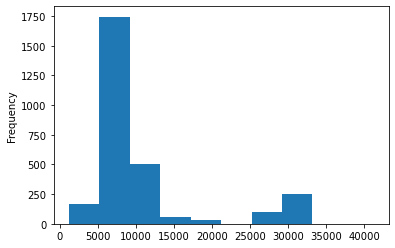

In [203]:
#look at length trend again

pndf.iloc[:2862, :]['Len'].plot(kind = 'hist')
pndf.iloc[2862:, :]['Len'].plot(kind = 'hist')

In [206]:
#length trend of other groups

#ssRNA(+/-)
t = df.loc[df['Gen'] == 'ssRNA(+/-)']
t['Len'] = [len(s) for s in t['Seq'].to_list()]
t.loc[t['Len'] > 5000]

#none greater than 7000

#ssRNA-RT
t = df.loc[df['Gen'] == 'ssRNA-RT']
t['Len'] = [len(s) for s in t['Seq'].to_list()]
t.loc[t['Len'] > 14000]

#none over 14k

#ssRNA
#viroids, none over 400

#dsRNA
#only 2 over 9k. none over 12k.

<ipython-input-206-2517287b1cfd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['Len'] = [len(s) for s in t['Seq'].to_list()]


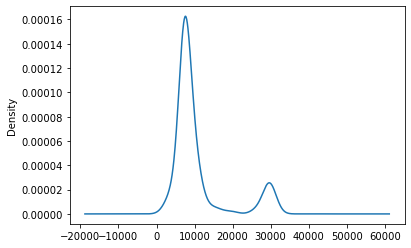

In [230]:
pndf.iloc[:2862, :]['Len'].plot(kind = 'kde')

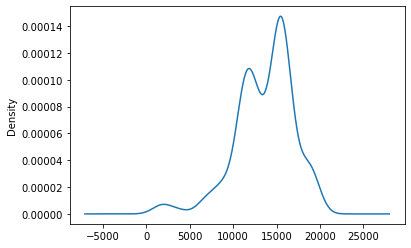

In [229]:
pndf.iloc[2862:, :]['Len'].plot(kind = 'kde')

In [238]:
pndf.iloc[2862:, :].loc[pndf.iloc[2862:, :]['Len'] < 2000]

,Id,Org,MolTyp,Topol,Des,Gen,Seq,Len,Tax
2980,NC_005218.1,Hantaan orthohantavirus,ss-RNA,linear,"Hantaan virus, complete genome",ssRNA(-),TAGTAGTAGACTCCCTAAAGAGCTACTAGAACAACGATGGCAACTA...,1696,"['Viruses', 'Riboviria', 'Negarnaviricota', 'P..."
2982,NC_005227.2,Tula orthohantavirus,cRNA,linear,"Tula virus segment S, complete genome",ssRNA(-),TAGTAGTAGACTCCTTGAAAAGCTACTACTAAAACCGCTGGTATGA...,1831,"['Viruses', 'Riboviria', 'Negarnaviricota', 'P..."
2993,NC_006433.1,Hantavirus Z10,RNA,linear,"Hantavirus Z10 chromosome S segment, complete ...",ssRNA(-),TAGTAGTAGACTCCCTAAAGAGCTACTATAACAACGATGGCAACTA...,1701,"['Viruses', 'Riboviria', 'Negarnaviricota', 'P..."
3093,NC_029122.1,Tofla virus,cRNA,linear,"Tofla virus viral cRNA, complete genome, segme...",ssRNA(-),TCTCAAAGACAAACGTGCCGCATACGCCCCACGTTTTCACAGACCT...,1699,"['Viruses', 'Riboviria', 'Negarnaviricota', 'P..."


In [236]:
pndf.iloc[:2862, :].loc[pndf.iloc[:2862, :]['Len'] < 5000]

,Id,Org,MolTyp,Topol,Des,Gen,Seq,Len,Tax
62,LC523031.1,Nectarine stem pitting associated virus,RNA,linear,Nectarine stem pitting associated virus TAS17 ...,ssRNA(+),AGTAAAGTTTGACTGACTTTACAAGACTGGGGCTTCCTTGTTCCCG...,4991,"['Viruses', 'Riboviria', 'Luteoviridae', 'Lute..."
183,NC_040434.1,Sclerotinia sclerotiorum mitovirus 2,RNA,linear,"Sclerotinia sclerotiorum mitovirus 2, complete...",ssRNA(+),GGTTTTCGTGATCGTATCACGAATACCACGGAGACCCCCAGGGGTA...,2445,"['Viruses', 'Riboviria', 'Narnaviridae', 'Mito..."
187,NC_040543.1,Chenopodium quinoa mitovirus 1,RNA,linear,"Chenopodium quinoa mitovirus 1 isolate Che1, c...",ssRNA(+),TCCGAATCTCATTTTCGGAGTGGGTAGACGTCTTTCAGTCTACGCA...,2730,"['Viruses', 'Riboviria', 'Narnaviridae', 'Mito..."
194,NC_040559.1,Gigaspora margarita mitovirus 3,RNA,linear,Gigaspora margarita mitovirus 3 isolate GmMV3-...,ssRNA(+),ACGCAGAGTACATGGGGGGGGCACACCCGGCGTCGCAGCCGGGACA...,3387,"['Viruses', 'Riboviria', 'Narnaviridae', 'Mito..."
195,NC_040560.1,Gigaspora margarita mitovirus 4,RNA,linear,Gigaspora margarita mitovirus 4 isolate GmMV4-...,ssRNA(+),ACATGGGGGGGGCACCCCCGGTGATGAACCGGGCCAGAGGAGAATA...,3389,"['Viruses', 'Riboviria', 'Narnaviridae', 'Mito..."
...,...,...,...,...,...,...,...,...,...
2685,DQ011234.1,Lisianthus necrosis virus,RNA,linear,"Lisianthus necrosis virus, complete genome",ssRNA(+),AGAAATTCCTCAGATTTCTCCCTGTGACCCGGGGTTATCGGTGAGT...,4764,"['Viruses', 'Riboviria', 'Tombusviridae', 'Pro..."
2732,AJ243370.1,Pothos latent virus,RNA,linear,"Pothos latent virus complete genome, pigeonpea...",ssRNA(+),GCCTAACCAGCTTGTTGAGAGTTGTGGAGCCATCCATATAGTTATT...,4354,"['Viruses', 'ssRNA viruses', 'ssRNA positive-s..."
2841,AF061869.1,Beet soil-borne mosaic virus,RNA,linear,"Beet soil-borne mosaic virus RNA2, complete ge...",ssRNA(+),GGATTCTAATTATTATCTCCATTGAATAGAATTTCACCAACTATTG...,4616,"['Viruses', 'Riboviria', 'Benyviridae', 'Benyv..."
2855,AF227250.1,Enterobacteria phage KU1,RNA,linear,"Enterobacteriophage KU1, complete genome",ssRNA(+),GGTTGGCGCCCCTTTCGGGGCGCTTGCTTTCTTCCTTGAAGGCGCT...,3486,"['Viruses', 'Riboviria', 'Leviviridae', 'Leviv..."


In [215]:
df['Gen'].unique()

array(['dsDNA', 'ssRNA(+)', 'ssRNA(-)', 'dsDNA-RT', 'ssRNA-RT',
       'ssDNA(+/-)', 'ssRNA', 'ssDNA(-)', 'dsRNA', 'ssDNA', 'ssDNA(+)',
       'ssRNA(+/-)', 'dsDNA; ssDNA'], dtype=object)

In [ ]:
len(pndf.loc[pndf['Gen'] == 'ssRNA(-)'].loc[pndf['Len'] > 20000])

#9 over 19k, none over 20k

In [3]:
dfp['Len'] = [len(s) for s in dfp['Seq'].to_list()]
dfn['Len'] = [len(s) for s in dfn['Seq'].to_list()]

dfp = dfp.sort_values('Len').reset_index(drop = True)
dfn = dfn.sort_values('Len').reset_index(drop = True)

dfp['GC'] = [SeqUtils.GC(dfp.loc[i,'Seq']) for i in range(len(dfp))]
dfn['GC'] = [SeqUtils.GC(dfn.loc[i,'Seq']) for i in range(len(dfn))]

<ipython-input-3-f6b3f534691f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp['Len'] = [len(s) for s in dfp['Seq'].to_list()]
<ipython-input-3-f6b3f534691f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn['Len'] = [len(s) for s in dfn['Seq'].to_list()]


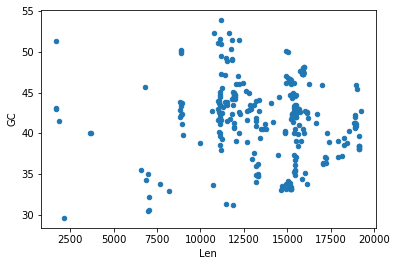

In [38]:
dfn.plot(x = 'Len', y = 'GC', kind='scatter')

In [43]:
dfp.loc[dfp['GC'] > 65 ] 

,Id,Org,MolTyp,Topol,Des,Gen,Seq,Len,GC
1573,NC_003347.1,Grapevine fleck virus,RNA,linear,"Grapevine fleck virus, complete genome",ssRNA(+),GCACATTAGTACTGACCACCAGCCCGACTTTGACGCCACCCTGTCC...,7564,66.234796
2115,MH745077.1,Rubella virus genotype 2B,RNA,linear,Rubella virus genotype 2B strain RVi/Pune.IND/...,ssRNA(+),CAATGGGAGCTACCGGACCTCGCTTAGGACTCCTATTCCCATGGAG...,9761,69.664993
2116,NC_001545.2,Rubella virus,ss-RNA,linear,"Rubella virus, complete genome",ssRNA(+),CAATGGAAGCTATCGGACCTCGCTTAGGACTCCCATTCCCATGGAG...,9762,69.596394
2117,MK780807.1,Rubella virus genotype 1A,RNA,linear,Rubella virus genotype 1A strain RVs/Oulu.FIN/...,ssRNA(+),CAATGGGAGCTATCGGACCTCGCTTAGGACTCCTATTCCCATGGAG...,9762,67.885679


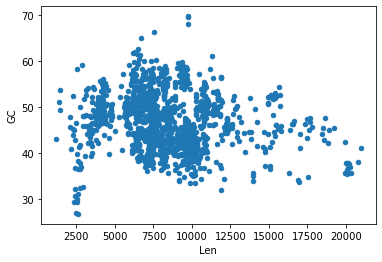

In [42]:
dfp.loc[dfp['Len'] < 25000].plot(x = 'Len', y = 'GC', kind='scatter')

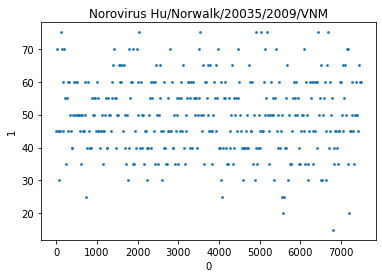

KeyboardInterrupt: 

In [97]:
#looking at distribution of gc contenct in a genome

def gc_plotter(seq, winsize):
    qgc = []
    for i in range(0, len(seq) - winsize + 1, winsize):
        query = seq[i: i + winsize]
        gc = SeqUtils.GC(query)
        qgc.append([i, gc])
        
    return qgc

import time
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

for i,r in dfp.loc[dfp['Len'] > 5000].iterrows():
    pd.DataFrame(gc_plotter(r['Seq'],20)).plot(x = 0, y = 1, kind='scatter', s = 3)
    plt.title(r['Org'])
    plt.show()
    time.sleep(3)
    clear_output(wait=True)

In [ ]:
looking at transition matrices

In [31]:
lp = dfp.loc[350, 'Seq']
sp = dfp.loc[3867, 'Seq']
ln = dfn.loc[3127, 'Seq']
sn = dfn.loc[2853, 'Seq']

In [34]:
tlp = transition_matrix(lp)
tsp = transition_matrix(sp)
tln = transition_matrix(ln)
tsn = transition_matrix(sn)

In [40]:
print(tlp, '\n\n', tsp, '\n\n', tln, '\n\n', tsn)

[[0.36805428 0.36768751 0.11290421 0.15135399]
 [0.37258244 0.32278622 0.20414969 0.10048166]
 [0.41290538 0.30508191 0.13306586 0.14894684]
 [0.53173563 0.24321288 0.10934282 0.11570867]] 

 [[0.29180328 0.27213115 0.20655738 0.2295082 ]
 [0.24184783 0.29619565 0.20108696 0.26086957]
 [0.22821577 0.3526971  0.22406639 0.19502075]
 [0.26865672 0.34328358 0.18656716 0.20149254]] 

 [[0.27566441 0.28243877 0.23866597 0.20323085]
 [0.25234002 0.26399236 0.27201528 0.21165234]
 [0.34069549 0.22086466 0.2481203  0.19031955]
 [0.35276306 0.32500631 0.1014383  0.22079233]] 

 [[0.27378641 0.2776699  0.26213592 0.18640777]
 [0.24336283 0.2920354  0.26769912 0.19690265]
 [0.31761787 0.18114144 0.30769231 0.19354839]
 [0.42153846 0.31692308 0.07076923 0.19076923]]


In [48]:
#calculate score and count

def calculate_score_count(tm, sequence):
    score_lst = []
    
    states = []
    
    for letter in sequence:
        if letter == 'A':
            states.append(0)
        elif letter == 'T':
            states.append(1)
        elif letter == 'G':
            states.append(2)
        elif letter == 'C':
            states.append(3) 
    
    old_state = states[0]
    for state in states[1:]:
        
        if tm[state, old_state] != 0:
            score_lst.append(tm[state, old_state])
        old_state = state
    
    score = np.prod(score_lst)
    
    count = 0
    return (score, count)

workflow

In [25]:
for repseq in repseqs:
    
    score_df = pd.DataFrame(index = list(range(len(working_df['Seq']))))
    count_df = pd.DataFrame(index = list(range(len(working_df['Seq']))))
    
    for i in range(0, (len(repseq) - window_size), window_size):
        query = repseq[i:(i + window_size)]
        tm = transition_matrix(query)
        (max_score, count) = calculate_score_count(tm, query)
        
        #print('made %d st tm and query' % i)
        
        #starting db seach
        
        for searchseq in working_df['Seq']:
            searchseq = str(searchseq)
            
            score_list = []
            count_list = []
            temp = 0
            
            #define separate functions for score and count?
            
            for i in range(0, (len(searchseq) - window_size) ):
                current_window = searchseq[i: (i + window_size)]
                (score, count) = calculate_score_count(tm, current_window)
                
                temp = score/max_score + temp
                
            score_list.append(temp)
            #count_list.append(count)
            
        score_df[query] = score_list
        #count_df[query] = count_list

all the rough code

In [26]:
score_df

,GATACAATACATATACAAAAAAAATT
0,61.934678


In [39]:
t = transition_matrix('GATACAATACATATACAAAAAAAATT')

In [49]:
calculate_score_count(t, 'GATACAATACATATACAAAAAAAATT')

(1.6093254089355476e-08, 0)

In [57]:
calculate_score_count(t, 'GATACAATACATATACACAATAAATT')

(1.2069940567016607e-08, 0)

In [70]:
8 * (101-9)

736

In [69]:
6 * (101-7)

564

In [63]:
score_df

,GATACAATACATA,TACAAAAAAAATT
0,486.333333,354.0


In [60]:
score_df

,GATACAA,TACATAT,ACAAAAA,AAATTTT
0,253.333333,230.333333,144.0,75.0


In [44]:
len(current_window)

15

In [12]:
df

""
0
1
2
3
4
5
6
7
8
9


In [10]:
score_list

[1.0,
 0.0,
 1.0,
 0.0,
 1.3333333333333333,
 0.0,
 1.3333333333333333,
 0.0,
 0.3333333333333333,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3333333333333333,
 1.0,
 0.3333333333333333,
 1.0,
 0.3333333333333333,
 1.0,
 0.3333333333333333,
 1.0,
 0.3333333333333333,
 1.0,
 0.6666666666666666,
 2.0,
 0.6666666666666666,
 1.0,
 0.6666666666666666,
 2.0,
 0.6666666666666666,
 1.0,
 0.3333333333333333,
 2.0,
 0.6666666666666666,
 2.0,
 0.6666666666666666,
 2.3333333333333335,
 1.0,
 1.6666666666666665,
 1.0,
 1.0,
 1.0,
 1.0,
 1.6666666666666665,
 1.0,
 2.333333333333333,
 1.0,
 3.0,
 1.0,
 3.0,
 1.0,
 3.0,
 1.0,
 2.3333333333333335,
 1.6666666666666665,
 1.6666666666666665,
 2.333333333333333]

In [8]:
for i in working_df['Seq']:
    print(str(i))

ATCGCGATTAGCCCCTGGGTACCCGTACGTATAGACAGATACAAAAAAAATATACACACAATACA


In [107]:
len(repseq)/window_size

3.1666666666666665

In [101]:
list(range(int(len(repseq) / window_size)))

[0, 1]

In [98]:
list(range(int(len(repseq) / window_size)))

[0, 1]

In [108]:
score_df

,0,1,2


In [72]:
count_df

,0,1


In [62]:
x

array([[0. , 0.5, 0. , 0.5],
       [1. , 0. , 0. , 0. ],
       [1. , 0. , 0. , 0. ],
       [1. , 0. , 0. , 0. ]])

In [56]:
x = x[1:,1:]

In [53]:
x = np.array(m)

In [47]:
19/5

3.8

In [46]:
for i in range(0,19,5):
    print(i)

0
5
10
15


In [48]:
list(range(0,5))

[0, 1, 2, 3, 4]

In [33]:
df = pd.DataFrame([(1,2,3,4),(2,3,4,5)])

In [34]:
df.append([(5,6,7,8)], ignore_index = True)

,0,1,2,3
0,1,2,3,4
1,2,3,4,5
2,5,6,7,8


In [15]:
for i in range(0,100,10):
    print(i+10)

10
20
30
40
50
60
70
80
90
100


In [11]:
t = [3,1,2,1,4,1]
for i, j in (zip(t,(t[1:] + [2,4,4]))):
    print(i,j)

3 1
1 2
2 1
1 4
4 1
1 2


In [16]:
df = pd.read_csv('resultp window 1.csv')

In [17]:
df

,A,T,G,C
0,16012.500,16615.625,13167.625,12814.625
1,5359.250,4669.750,4257.250,4076.750
2,5655.125,5147.875,4954.250,4514.750
3,14255.250,16647.750,13423.125,12262.250
4,6742.875,5660.000,6186.125,5583.625
...,...,...,...,...
2857,3735.875,3567.750,3597.625,3673.250
2858,4028.125,4489.875,5001.375,4658.125
2859,6892.750,5698.375,6125.000,5484.500
2860,2030.000,2114.500,2147.500,2075.000


In [63]:
#!/Users/Rad/anaconda/bin/python
# (c) 2013 Ryan Boehning


'''A Python implementation of the Smith-Waterman algorithm for local alignment
of nucleotide sequences.
'''


import argparse
import os
import re
import sys
import unittest


# These scores are taken from Wikipedia.
# en.wikipedia.org/wiki/Smith%E2%80%93Waterman_algorithm
match    = 2
mismatch = -1
gap      = -1
seq1     = 'GATACA'
seq2     = 'ATACAGATACACACATAGATACAATATTTTTGATACATTATAGATACATTTATACATTTTGTGACA'


def main():
    try:
        parse_cmd_line()
    except ValueError as err:
        print('error:', err)
        return

    # The scoring matrix contains an extra row and column for the gap (-), hence
    # the +1 here.
    rows = len(seq1) + 1
    cols = len(seq2) + 1

    # Initialize the scoring matrix.
    score_matrix, start_pos = create_score_matrix(rows, cols)

    # Traceback. Find the optimal path through the scoring matrix. This path
    # corresponds to the optimal local sequence alignment.
    seq1_aligned, seq2_aligned = traceback(score_matrix, start_pos)
    assert len(seq1_aligned) == len(seq2_aligned), 'aligned strings are not the same size'

    # Pretty print the results. The printing follows the format of BLAST results
    # as closely as possible.
    alignment_str, idents, gaps, mismatches = alignment_string(seq1_aligned, seq2_aligned)
    alength = len(seq1_aligned)
    print()
    print(' Identities = {0}/{1} ({2:.1%}), Gaps = {3}/{4} ({5:.1%})'.format(idents,
          alength, idents / alength, gaps, alength, gaps / alength))
    print()
    for i in range(0, alength, 60):
        seq1_slice = seq1_aligned[i:i+60]
        print('Query  {0:<4}  {1}  {2:<4}'.format(i + 1, seq1_slice, i + len(seq1_slice)))
        print('             {0}'.format(alignment_str[i:i+60]))
        seq2_slice = seq2_aligned[i:i+60]
        print('Sbjct  {0:<4}  {1}  {2:<4}'.format(i + 1, seq2_slice, i + len(seq2_slice)))
        print()


def parse_cmd_line():
    '''Parse the command line arguments.
    Create a help menu, take input from the command line, and validate the
    input by ensuring it does not contain invalid characters (i.e. characters
    that aren't the bases A, C, G, or T).
    '''



    seq1 = "ATAGACGACATACAGACAGCATACAGACAGCATACAGA"
    seq2 = "TTTAGCATGCGCATATCAGCAATACAGACAGATACG"


def create_score_matrix(rows, cols):
    '''Create a matrix of scores representing trial alignments of the two sequences.
    Sequence alignment can be treated as a graph search problem. This function
    creates a graph (2D matrix) of scores, which are based on trial alignments
    of different base pairs. The path with the highest cummulative score is the
    best alignment.
    '''
    score_matrix = [[0 for col in range(cols)] for row in range(rows)]

    # Fill the scoring matrix.
    max_score = 0
    max_pos   = None    # The row and columbn of the highest score in matrix.
    for i in range(1, rows):
        for j in range(1, cols):
            score = calc_score(score_matrix, i, j)
            if score > max_score:
                max_score = score
                max_pos   = (i, j)

            score_matrix[i][j] = score

    assert max_pos is not None, 'the x, y position with the highest score was not found'

    return score_matrix, max_pos


def calc_score(matrix, x, y):
    '''Calculate score for a given x, y position in the scoring matrix.
    The score is based on the up, left, and upper-left neighbors.
    '''
    similarity = match if seq1[x - 1] == seq2[y - 1] else mismatch

    diag_score = matrix[x - 1][y - 1] + similarity
    up_score   = matrix[x - 1][y] + gap
    left_score = matrix[x][y - 1] + gap

    return max(0, diag_score, up_score, left_score)


def traceback(score_matrix, start_pos):
    '''Find the optimal path through the matrix.
    This function traces a path from the bottom-right to the top-left corner of
    the scoring matrix. Each move corresponds to a match, mismatch, or gap in one
    or both of the sequences being aligned. Moves are determined by the score of
    three adjacent squares: the upper square, the left square, and the diagonal
    upper-left square.
    WHAT EACH MOVE REPRESENTS
        diagonal: match/mismatch
        up:       gap in sequence 1
        left:     gap in sequence 2
    '''

    END, DIAG, UP, LEFT = range(4)
    aligned_seq1 = []
    aligned_seq2 = []
    x, y         = start_pos
    move         = next_move(score_matrix, x, y)
    while move != END:
        if move == DIAG:
            aligned_seq1.append(seq1[x - 1])
            aligned_seq2.append(seq2[y - 1])
            x -= 1
            y -= 1
        elif move == UP:
            aligned_seq1.append(seq1[x - 1])
            aligned_seq2.append('-')
            x -= 1
        else:
            aligned_seq1.append('-')
            aligned_seq2.append(seq2[y - 1])
            y -= 1

        move = next_move(score_matrix, x, y)

    aligned_seq1.append(seq1[x - 1])
    aligned_seq2.append(seq2[y - 1])

    return ''.join(reversed(aligned_seq1)), ''.join(reversed(aligned_seq2))


def next_move(score_matrix, x, y):
    diag = score_matrix[x - 1][y - 1]
    up   = score_matrix[x - 1][y]
    left = score_matrix[x][y - 1]
    if diag >= up and diag >= left:     # Tie goes to the DIAG move.
        return 1 if diag != 0 else 0    # 1 signals a DIAG move. 0 signals the end.
    elif up > diag and up >= left:      # Tie goes to UP move.
        return 2 if up != 0 else 0      # UP move or end.
    elif left > diag and left > up:
        return 3 if left != 0 else 0    # LEFT move or end.
    else:
        # Execution should not reach here.
        raise ValueError('invalid move during traceback')


def alignment_string(aligned_seq1, aligned_seq2):
    '''Construct a special string showing identities, gaps, and mismatches.
    This string is printed between the two aligned sequences and shows the
    identities (|), gaps (-), and mismatches (:). As the string is constructed,
    it also counts number of identities, gaps, and mismatches and returns the
    counts along with the alignment string.
    AAGGATGCCTCAAATCGATCT-TTTTCTTGG-
    ::||::::::||:|::::::: |:  :||:|   <-- alignment string
    CTGGTACTTGCAGAGAAGGGGGTA--ATTTGG
    '''
    # Build the string as a list of characters to avoid costly string
    # concatenation.
    idents, gaps, mismatches = 0, 0, 0
    alignment_string = []
    for base1, base2 in zip(aligned_seq1, aligned_seq2):
        if base1 == base2:
            alignment_string.append('|')
            idents += 1
        elif '-' in (base1, base2):
            alignment_string.append(' ')
            gaps += 1
        else:
            alignment_string.append(':')
            mismatches += 1

    return ''.join(alignment_string), idents, gaps, mismatches


def print_matrix(matrix):
    '''Print the scoring matrix.
    ex:
    0   0   0   0   0   0
    0   2   1   2   1   2
    0   1   1   1   1   1
    0   0   3   2   3   2
    0   2   2   5   4   5
    0   1   4   4   7   6
    '''
    for row in matrix:
        for col in row:
            print('{0:>4}'.format(col))
        print()


class ScoreMatrixTest(unittest.TestCase):
    '''Compare the matrix produced by create_score_matrix() with a known matrix.'''
    def test_matrix(self):
        # From Wikipedia (en.wikipedia.org/wiki/Smith%E2%80%93Waterman_algorithm)
        #                -   A   C   A   C   A   C   T   A
        known_matrix = [[0,  0,  0,  0,  0,  0,  0,  0,  0],  # -
                        [0,  2,  1,  2,  1,  2,  1,  0,  2],  # A
                        [0,  1,  1,  1,  1,  1,  1,  0,  1],  # G
                        [0,  0,  3,  2,  3,  2,  3,  2,  1],  # C
                        [0,  2,  2,  5,  4,  5,  4,  3,  4],  # A
                        [0,  1,  4,  4,  7,  6,  7,  6,  5],  # C
                        [0,  2,  3,  6,  6,  9,  8,  7,  8],  # A
                        [0,  1,  4,  5,  8,  8, 11, 10,  9],  # C
                        [0,  2,  3,  6,  7, 10, 10, 10, 12]]  # A

        global seq1, seq2
        seq1 = 'AGCACACA'
        seq2 = 'ACACACTA'
        rows = len(seq1) + 1
        cols = len(seq2) + 1

        matrix_to_test, max_pos = create_score_matrix(rows, cols)
        self.assertEqual(known_matrix, matrix_to_test)


if __name__ == '__main__':
    sys.exit(main())
    
%tb


 Identities = 6/6 (100.0%), Gaps = 0/6 (0.0%)

Query  1     GATACA  6   
             ||||||
Sbjct  1     GATACA  6   



SystemExit: 